## Importamos el dataset

In [1]:
import pandas as pd
import numpy as np
dataset = pd.read_csv("properati_clean.csv", index_col = 'Unnamed: 0')

In [2]:
dataset = dataset.loc[dataset.state_name == 'Capital Federal']

In [3]:
dataset.sample(3)

,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,pileta,galeria,seguridad,sotano,amenities,terraza,metrobus,subte,cochera,consultorio
51460,51460,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5623719887,-58.4501033935",-34.562372,...,False,False,False,False,False,False,False,False,True,False
70056,70056,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.5777768214,-58.4243003491",-34.577777,...,True,False,True,False,False,True,False,False,True,False
93928,93928,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,...,True,False,True,False,True,False,False,True,True,False


## Agrupacion de barrios con pocos datos en la muestra

Vemos que en la columna de barrios, hay algunos que tienen pocos registros

In [4]:
dataset.place_name.value_counts()

Belgrano           2984
Palermo            2867
Caballito          2271
Villa Urquiza      1626
Recoleta           1543
                   ... 
Velez Sarsfield      39
Villa Real           37
Villa Soldati        15
Villa Riachuelo       6
Catalinas             4
Name: place_name, Length: 62, dtype: int64

En particular, vemos que barrios como Villa Soldati, Velez Sarsfield, Villa Riachuelo, etc. tienen pocos registros

In [5]:
dataset.place_name.value_counts().describe()

count      62.000000
mean      519.225806
std       651.674902
min         4.000000
25%        88.250000
50%       252.500000
75%       592.500000
max      2984.000000
Name: place_name, dtype: float64

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='place_name'>

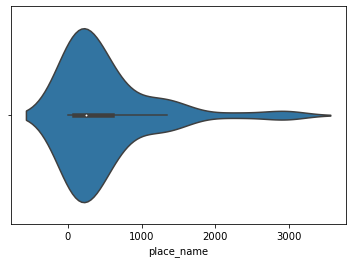

In [6]:
import seaborn as sns
sns.violinplot(dataset.place_name.value_counts())

Para balancear un poco esta situacion, vamos a agrupar los barrios con pocos registros en uno solo llamado "Otros barrios". La columna place_name, pasara a llamarse "place_name_raw" y la aplicacion que haremos quedara en "place_name". Vamos a tomar todos los barrios cuya cantidad de datos esta por debajo del percentil 25.

In [7]:
dataset["place_name_raw"] = dataset.place_name.copy()

In [8]:
barrios_por_presencia = dataset.place_name.value_counts()
percentil = barrios_por_presencia.quantile(.25)

In [9]:
barrios_para_agrupar = barrios_por_presencia[barrios_por_presencia < percentil].index.tolist()

In [10]:
print(f"Vamos a agrupar los siguientes varrios {barrios_para_agrupar}")

Vamos a agrupar los siguientes varrios ['Villa Ortuzar', 'Monte Castro', 'Parque Centenario', 'Pompeya', 'Villa Santa Rita', 'Parque Avellaneda', 'Versalles', 'Villa General Mitre', 'Parque Chas', 'Agronomía', 'Palermo Viejo', 'Velez Sarsfield', 'Villa Real', 'Villa Soldati', 'Villa Riachuelo', 'Catalinas']


In [11]:
dataset["place_name"] = np.where(dataset.place_name.isin(barrios_para_agrupar), "Otros barrios", dataset.place_name)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='place_name'>

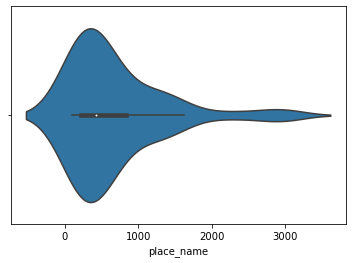

In [12]:
sns.violinplot(dataset.place_name.value_counts())

## Eliminacion de outliers

Eliminamos outliers en precio por metro cuadrado utilizando los rangos intercuartiles

In [13]:
def get_outlier_bounds(series):
    # Compute quartiles
    q1 = series.quantile(0.25)
    q2 = series.quantile(0.5)
    q3 = series.quantile(0.75)

    # Compute interquartile range
    iqr = q3 - q1

    # Compute outlier thresholds
    up_threshold = q3 + 1.5 * iqr
    low_threshold = q1 - 1.5* iqr
    
    return low_threshold, up_threshold

In [14]:
lower, upper = get_outlier_bounds(dataset.price_usd_per_m2)

In [15]:
def price_m2_is_not_outlier(price_usd_per_m2):
    return (lower <= price_usd_per_m2) & (price_usd_per_m2 <= upper)

price_m2_is_not_outlier_mask = dataset.price_usd_per_m2.apply(price_m2_is_not_outlier)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price_usd_per_m2'>

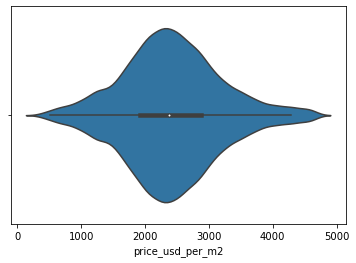

In [16]:
import seaborn as sns
sns.violinplot(dataset[price_m2_is_not_outlier_mask].price_usd_per_m2)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price_usd_per_m2'>

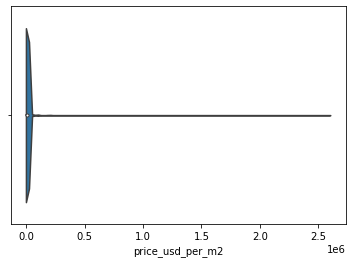

In [17]:
import seaborn as sns
sns.violinplot(dataset.price_usd_per_m2)

Exploramos la distribución en la cantidad de ambientes

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rooms_3'>

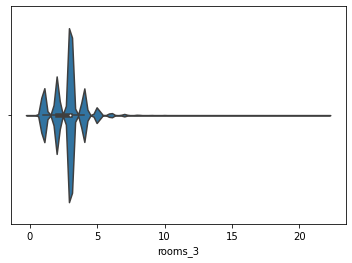

In [18]:
import seaborn as sns
sns.violinplot(dataset.rooms_3)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='rooms_3'>

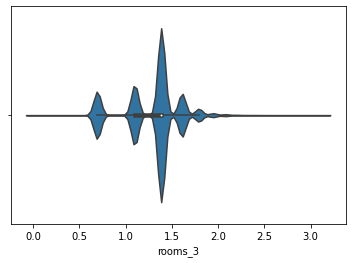

In [19]:
import seaborn as sns
sns.violinplot(np.log(1 + dataset.rooms_3))

Exploramos la distribución de superficie

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='surface_covered_in_m2'>

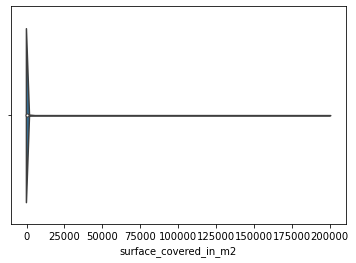

In [20]:
sns.violinplot(dataset.surface_covered_in_m2)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='surface_total_in_m2'>

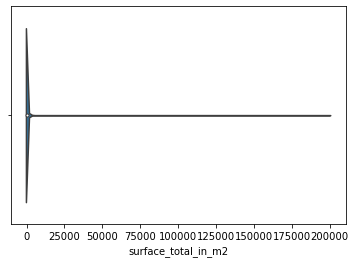

In [21]:
sns.violinplot(dataset.surface_total_in_m2)

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='surface_total_in_m2'>

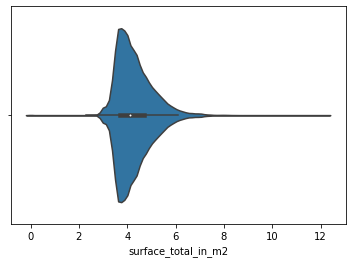

In [22]:
sns.violinplot(np.log(dataset.surface_total_in_m2))

Elimino efectivamente los outliers de precio

In [23]:
outlier = (~price_m2_is_not_outlier_mask).sum()
total = dataset.shape[0]
outlier_percentage = 100 * outlier / total
print(f"Consideramos {outlier_percentage:.2f}% como outliers")

Consideramos 20.80% como outliers


En lugar de truncar el dataset, los valores outliers los capeamos

In [24]:
dataset = dataset[price_m2_is_not_outlier_mask]

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price_usd_per_m2'>

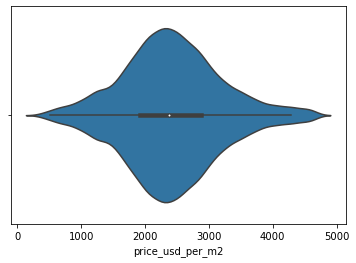

In [25]:
sns.violinplot(dataset['price_usd_per_m2'])

## Feature engineering

Creo una columna con el cuadrado de la cantidad de ambientes

In [26]:
dataset['rooms_log'] = np.log(1 + dataset['rooms_3'])
dataset['rooms_log_squared'] = dataset['rooms_log'] ** 2
dataset['surface_uncovered'] = dataset['surface_total_in_m2'] - dataset['surface_covered_in_m2']
dataset['surface_uncovered_log'] = np.log(1 + dataset.surface_uncovered)
dataset['has_surface_uncovered'] = dataset['surface_uncovered'] > 0
dataset['surface_total_log'] = np.log(dataset.surface_total_in_m2)
dataset['surface_total_log_squared'] = np.log(dataset.surface_total_in_m2) ** 2

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='surface_total_in_m2'>

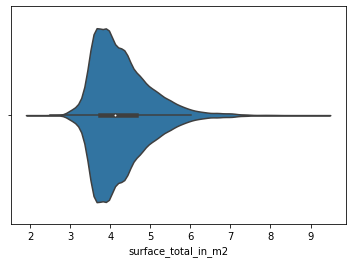

In [27]:
sns.violinplot(np.log(dataset.surface_total_in_m2))

C:\Users\carlm\anaconda3\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='surface_uncovered_log'>

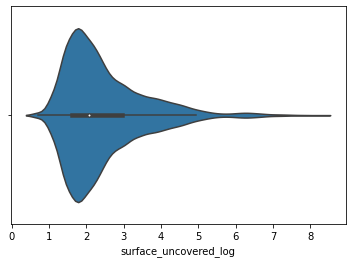

In [28]:
sns.violinplot(dataset[dataset.has_surface_uncovered].surface_uncovered_log)

In [29]:
dataset.surface_uncovered.describe()

count    25432.000000
mean        18.844448
std         94.182652
min       -300.000000
25%          0.000000
50%          4.000000
75%          9.000000
max       3721.000000
Name: surface_uncovered, dtype: float64

In [30]:
dataset.has_surface_uncovered.value_counts()

True     15382
False    10114
Name: has_surface_uncovered, dtype: int64

In [31]:
dataset.groupby('has_surface_uncovered').price_usd_per_m2.describe()

,count,mean,std,min,25%,50%,75%,max
has_surface_uncovered,,,,,,,,
False,10114.0,2413.958360,769.699766,343.51145,1914.285714,2345.454545,2857.142857,4690.666667
True,15382.0,2415.973944,783.269776,340.00000,1934.620366,2400.000000,2879.310345,4695.652174


## Crear variables dummies

In [32]:
dicotomical = [
    'pileta',
    'galeria',
    'seguridad',
    'sotano',
    'amenities',
    'terraza',
    'metrobus',
    'subte',
    'cochera',
    'consultorio',
    'has_surface_uncovered'
]

categorical = [
    'property_type',
    'place_name',
]

In [33]:
# Por cada columna categorica o dicotomica, agrego dummies
for column in dicotomical + categorical:
    dummies = pd.get_dummies(dataset[column], prefix = column, drop_first = True)
    dataset = dataset.join(dummies)

In [34]:
dataset.columns

Index(['Unnamed: 0.1', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat',
       ...
       'place_name_San Nicolás', 'place_name_San Telmo',
       'place_name_Tribunales', 'place_name_Villa Crespo',
       'place_name_Villa Devoto', 'place_name_Villa Lugano',
       'place_name_Villa Luro', 'place_name_Villa Pueyrredón',
       'place_name_Villa Urquiza', 'place_name_Villa del Parque'],
      dtype='object', length=111)

Guardo el nombre de las columnas dummies para usarlas mas adelante

In [35]:
dicotomical_features = [name + '_True' for name in dicotomical]
categorical_features = [column for name in categorical for column in dataset.columns if name + '_' in column and "_raw" not in column]

In [36]:
dicotomical_features

['pileta_True',
 'galeria_True',
 'seguridad_True',
 'sotano_True',
 'amenities_True',
 'terraza_True',
 'metrobus_True',
 'subte_True',
 'cochera_True',
 'consultorio_True',
 'has_surface_uncovered_True']

## Drop nulls para las columnas que nos interesan

Columnas que ya teniamos que eran numericas

In [37]:
numerical = [
    # 'surface_covered_in_m2',
    # 'surface_total_in_m2',
    'rooms_log',
    'rooms_log_squared',
    'surface_covered_in_m2',
    'surface_uncovered_log',
    'surface_total_log',
    'surface_total_log_squared'
]

Me guardo los nombres de las columnas que nos interesan, las categoricas, dicotomicas y numericas

In [38]:
columns_to_use = categorical_features + dicotomical_features + numerical
target_col = 'price_usd_per_m2'
cluster = 'place_name'

In [39]:
dataset = dataset.dropna(subset = columns_to_use + [target_col, cluster])

## Dividir en train y test

Divido en train y test, utilizando los índices que existen en el dataset. Notese que estratificamos por los barrios sin agrupacion, esto es porque aunque estamos agrupando para ayudar al algoritmo a aprender haciendo un barrio virtual mas grande, aun asi queremos testear el resultado de las predicciones sobre los barrios reales de capital.

In [40]:
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(dataset.index, test_size = .20, stratify = dataset.place_name_raw, random_state = 42)
print('Shape train = ', index_train.shape, 'Shape test = ', index_test.shape)

Shape train =  (20342,) Shape test =  (5086,)


## Escalar variables continuas

Columnas que crearemos que estarán escaladas

In [41]:
numerical_features = [
    # 'surface_covered_in_m2_scaled',
    # 'surface_total_in_m2_scaled',
    'rooms_log_scaled',
    'rooms_log_squared_scaled',
    'surface_covered_in_m2_scaled',
    'surface_uncovered_log_scaled',
    'surface_total_log_scaled',
    'surface_total_log_squared_scaled'
]

Aprovecho que partimos en train y test usando índices para usarlos con el standard scaler, de tal forma que podemos fitear utilizando solo valores de train, y transformamos todos los valores en el dataset.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dataset.loc[index_train, numerical])

dataframe_scaled = pd.DataFrame(scaler.transform(dataset.loc[:, numerical]), columns = numerical_features, index = dataset.index)

dataframe_scaled.sample(3)

,rooms_log_scaled,rooms_log_squared_scaled,surface_covered_in_m2_scaled,surface_uncovered_log_scaled,surface_total_log_scaled,surface_total_log_squared_scaled
24734,0.298357,0.195598,-0.164131,-1.008503,-0.238030,-0.284702
56219,1.018204,1.057052,-0.088780,0.882319,0.271835,0.172273
74184,0.298357,0.195598,-0.101339,0.489938,0.121990,0.033856


In [43]:
dataset = dataset.join(dataframe_scaled)

dataset.sample(3)

,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,place_name_Villa Luro,place_name_Villa Pueyrredón,place_name_Villa Urquiza,place_name_Villa del Parque,rooms_log_scaled,rooms_log_squared_scaled,surface_covered_in_m2_scaled,surface_uncovered_log_scaled,surface_total_log_scaled,surface_total_log_squared_scaled
31357,31357,sell,apartment,Floresta,|Argentina|Capital Federal|Floresta|,Argentina,Capital Federal,3433910.0,"-34.6252587,-58.4865042",-34.625259,...,0,0,0,0,0.298357,0.195598,-0.038546,0.489938,0.287517,0.186957
105884,105884,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.5882667924,-58.4389790805",-34.588267,...,0,0,0,0,1.018204,1.057052,-0.239482,-0.063092,-0.461041,-0.472108
110876,110876,sell,PH,Floresta,|Argentina|Capital Federal|Floresta|,Argentina,Capital Federal,3433910.0,"-34.62717,-58.495202",-34.627170,...,0,0,0,0,1.018204,1.057052,0.526585,-1.008503,1.191068,1.096384


## Prueba de modelos con KFold

Creo particiones de fold utilizando los índices de train

In [44]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3)

Creo un vector X e y utilizando las features y el target, posteriormente podremos filtrar utilizando los índices del dataframe.

In [45]:
feature_cols = categorical_features + dicotomical_features + numerical_features

In [46]:
X = dataset.loc[:, feature_cols]
y = dataset[target_col]

X_train_general = X.loc[index_train]

### Prueba de Regresión Lineal Múltiple

Realizamos Kfold ver la media de las metricas de performance de cada modelo. En el caso de Lasso y Ridge tambien usamos KFold para obtener el hiperparametro optimo

In [47]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import numpy as np

# Creo un DataFrame vacío con estas columnas para guardar los resultados de cada entrenamiento
# En la columna type me guardo si fueron resultados de train o test de cada Fold
results_columns = ['R2', 'MAE', 'MSE', 'RMSE', 'type']
results = pd.DataFrame(columns = results_columns)

# Enumero el kfold para guardarlo en el DataFrame de resultados
for i, (train_index, test_index) in enumerate(kf.split(X_train_general)):
    # Guardo datos de train y test para este fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    train_mae = mae(y_train, y_pred_train)
    test_mae = mae(y_test, y_pred_test)
    
    train_mse = mse(y_train, y_pred_train)
    test_mse = mse(y_test, y_pred_test)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # Me guardo los resultados en un DataFrame
    fold_results = [
        [train_r2, test_r2],
        [train_mae, test_mae],
        [train_mse, test_rmse],
        [train_rmse, test_rmse],
        ['train', 'test']
    ]
    fold_dataframe = pd.DataFrame(dict(zip(results_columns, fold_results)))
    results = pd.concat([results, fold_dataframe])

In [48]:
results.groupby('type').mean()

,R2,MAE,MSE,RMSE
type,,,,
test,0.532175,400.233258,529.311525,529.311525
train,0.570121,385.304653,262805.220894,512.624275


### Prueba de Regresión Lasso

In [49]:
from sklearn.linear_model import LassoCV

alphas = np.linspace(1e-5, 1, 100)
reg_lasso = LassoCV(cv=kf, alphas = alphas, tol = 0.001, max_iter = 1e6, random_state=0).fit(X, y)
best_alpha_lasso = reg_lasso.alpha_

In [50]:
best_alpha_lasso

0.030312727272727272

In [51]:
from sklearn.linear_model import Lasso

# Creo un DataFrame vacío con estas columnas para guardar los resultados de cada entrenamiento
# En la columna type me guardo si fueron resultados de train o test de cada Fold
results_columns = ['R2', 'MAE', 'MSE', 'RMSE', 'type']
results = pd.DataFrame(columns = results_columns)

# Enumero el kfold para guardarlo en el DataFrame de resultados
for i, (train_index, test_index) in enumerate(kf.split(X_train_general)):
    # Guardo datos de train y test para este fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Utilizo Lasso
    model = Lasso(max_iter = 10000, alpha = best_alpha_lasso)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    train_mae = mae(y_train, y_pred_train)
    test_mae = mae(y_test, y_pred_test)
    
    train_mse = mse(y_train, y_pred_train)
    test_mse = mse(y_test, y_pred_test)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # Me guardo los resultados en un DataFrame
    fold_results = [
        [train_r2, test_r2],
        [train_mae, test_mae],
        [train_mse, test_rmse],
        [train_rmse, test_rmse],
        ['train', 'test']
    ]
    fold_dataframe = pd.DataFrame(dict(zip(results_columns, fold_results)))
    results = pd.concat([results, fold_dataframe])

In [52]:
results.groupby('type').mean()

,R2,MAE,MSE,RMSE
type,,,,
test,0.532184,400.202482,529.317743,529.317743
train,0.570099,385.304025,262818.442103,512.637203


### Prueba de Regresión Lineal Ridge

In [53]:
from sklearn.linear_model import RidgeCV

alphas = np.linspace(1e-5, 1, 100)
reg_ridge = RidgeCV(cv=kf, alphas = alphas).fit(X, y)
best_alpha_ridge = reg_ridge.alpha_

In [54]:
best_alpha_ridge

0.41414727272727275

In [55]:
from sklearn.linear_model import Ridge

# Creo un DataFrame vacío con estas columnas para guardar los resultados de cada entrenamiento
# En la columna type me guardo si fueron resultados de train o test de cada Fold
results_columns = ['R2', 'MAE', 'MSE', 'RMSE', 'type']
results = pd.DataFrame(columns = results_columns)

# Enumero el kfold para guardarlo en el DataFrame de resultados
for i, (train_index, test_index) in enumerate(kf.split(X_train_general)):
    # Guardo datos de train y test para este fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Utilizo Ridge
    model = Ridge(max_iter = 10000, alpha = best_alpha_ridge)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    train_mae = mae(y_train, y_pred_train)
    test_mae = mae(y_test, y_pred_test)
    
    train_mse = mse(y_train, y_pred_train)
    test_mse = mse(y_test, y_pred_test)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # Me guardo los resultados en un DataFrame
    fold_results = [
        [train_r2, test_r2],
        [train_mae, test_mae],
        [train_mse, test_rmse],
        [train_rmse, test_rmse],
        ['train', 'test']
    ]
    fold_dataframe = pd.DataFrame(dict(zip(results_columns, fold_results)))
    results = pd.concat([results, fold_dataframe])

In [56]:
results.groupby('type').mean()

,R2,MAE,MSE,RMSE
type,,,,
test,0.532153,400.243685,529.32355,529.323550
train,0.570087,385.329769,262825.63435,512.644199


## Entrenamiento del modelo

Como vimos que en los tres tipos de regresion que probamos obtenemos resultados muy similares, decidimos optar por la regresion Lineal sin regularizacion, de tal forma que mas adelante, tambien, podamos hacer un intervalo de prediccion.

In [57]:
X_train, y_train = X.loc[index_train], y.loc[index_train]
X_test, y_test = X.loc[index_test], y.loc[index_test]

In [58]:
model = LinearRegression()
model.fit(X_train, y_train)
    
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
    
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
    
train_mae = mae(y_train, y_pred_train)
test_mae = mae(y_test, y_pred_test)
    
train_mse = mse(y_train, y_pred_train)
test_mse = mse(y_test, y_pred_test)
    
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

In [59]:
import matplotlib.pyplot as plt
palette = sns.color_palette("coolwarm", 2)

def show_barplot_with_values(values, labels):
    # Show barplot
    ax = sns.barplot(x = values, y = labels, palette = palette)
    values_to_show = [f"{x:.2f}" for x in values]
    
    # Show value on top of bar
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        width = p.get_width()
        y = p.get_y()
        ax.text(width / 2, y + height/2 + 0.1, values_to_show[i], ha="center", size = "large")
        
    # Display plot
    plt.show()

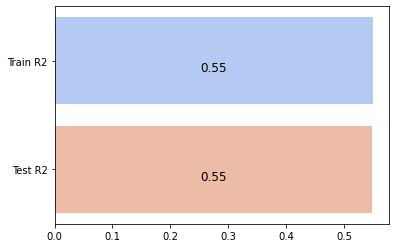

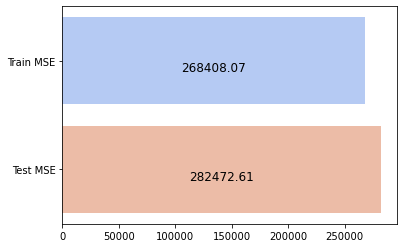

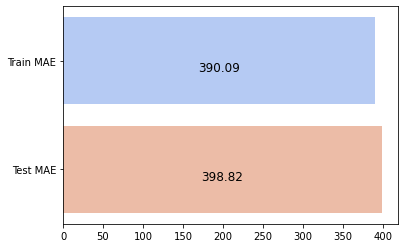

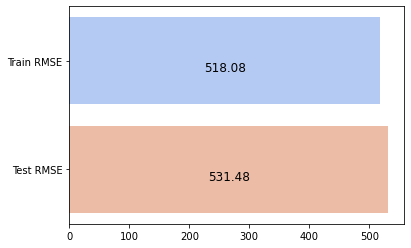

In [60]:
show_barplot_with_values([train_r2, test_r2], ['Train R2', 'Test R2'])
show_barplot_with_values([train_mse, test_mse], ['Train MSE', 'Test MSE'])
show_barplot_with_values([train_mae, test_mae], ['Train MAE', 'Test MAE'])
show_barplot_with_values([train_rmse, test_rmse], ['Train RMSE', 'Test RMSE'])

### Exploración de métricas del modelo barrios

In [61]:
indexed_dataset = dataset.set_index('Unnamed: 0.1')

full_test_dataset = pd.concat([indexed_dataset.loc[index_test], X_test, y_test], axis = 1)
full_test_dataset['y_pred'] = y_pred_test
full_test_dataset['y_true'] = y_test

In [62]:
rmse_by_place = {}

for place in full_test_dataset.place_name.unique():
    placemask = full_test_dataset.place_name == place
    y_true = full_test_dataset.loc[placemask].y_true
    y_pred = full_test_dataset.loc[placemask].y_pred
    rmse_by_place[place] = np.sqrt(mse(y_true, y_pred))
        
rmse_by_place = pd.DataFrame(rmse_by_place, index = ['rmse']).transpose()

<AxesSubplot:>

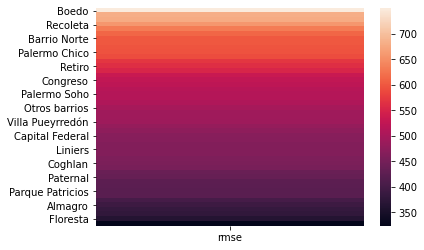

In [63]:
sns.heatmap(rmse_by_place.sort_values(by = 'rmse', ascending = False))

Exploramos los barrios con menor RMSE

In [64]:
less_error_places = rmse_by_place.sort_values(by = 'rmse').head(10)
less_error_places

,rmse
Puerto Madero,323.017285
Floresta,364.101478
Boca,378.684078
Balvanera,383.528998
Almagro,392.501002
Villa Luro,402.820220
Colegiales,421.973587
Parque Patricios,422.848465
Villa Urquiza,423.046115
Abasto,424.774213


Y la media de precios por metro cuadrado de esos barrios

In [65]:
mean_price_m2_by_place = full_test_dataset.groupby('place_name').mean()\
    .price_usd_per_m2.loc[less_error_places.index]\
    .iloc[:, [0]]

mean_price_m2_by_place

,price_usd_per_m2
Puerto Madero,4315.003745
Floresta,1830.808241
Boca,1589.681855
Balvanera,1919.229405
Almagro,2192.172405
Villa Luro,2115.772606
Colegiales,2511.093868
Parque Patricios,1803.721006
Villa Urquiza,2474.130102
Abasto,1980.424089


Exploro el ratio entre el rmse y la media de precio por metro cuadrado

In [66]:
less_error_places.rmse / mean_price_m2_by_place.price_usd_per_m2

Puerto Madero       0.074859
Floresta            0.198875
Boca                0.238214
Balvanera           0.199835
Almagro             0.179047
Villa Luro          0.190389
Colegiales          0.168044
Parque Patricios    0.234431
Villa Urquiza       0.170988
Abasto              0.214486
dtype: float64

## Analisis de portafolio

In [68]:
portafolio = dataset.sample(100, random_state = 42)
portafolio.head(3)

,Unnamed: 0.1,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,place_name_Villa Luro,place_name_Villa Pueyrredón,place_name_Villa Urquiza,place_name_Villa del Parque,rooms_log_scaled,rooms_log_squared_scaled,surface_covered_in_m2_scaled,surface_uncovered_log_scaled,surface_total_log_scaled,surface_total_log_squared_scaled
110357,110357,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.563643,-58.4594633",-34.563643,...,0,0,0,0,0.298357,0.195598,-0.164131,0.318549,-0.107244,-0.171266
22291,22291,sell,house,Villa Devoto,|Argentina|Capital Federal|Villa Devoto|,Argentina,Capital Federal,3427451.0,"-34.5873108,-58.511576",-34.587311,...,0,0,0,0,0.298357,0.195598,0.746358,-1.008503,1.447962,1.377695
111784,111784,sell,apartment,Monserrat,|Argentina|Capital Federal|Monserrat|,Argentina,Capital Federal,3430570.0,"-34.6197919041,-58.3813379478",-34.619792,...,0,0,0,0,0.298357,0.195598,-0.283436,0.318549,-0.573120,-0.563429


In [70]:
equity = (portafolio.price_usd_per_m2 * portafolio.surface_total_in_m2).sum()
print(f"Tengo {equity:.2f} USD")

Tengo 21702320.53 USD


In [71]:
price_usd_per_m2_pred = model.predict(dataset.loc[:, feature_cols])
dataset['price_usd_per_m2_pred'] = price_usd_per_m2_pred
dataset['price_aprox_usd_pred'] = price_usd_per_m2_pred * dataset.surface_total_in_m2

Armo un intervalo de prediccion con 95% de confianza

In [72]:
import scipy.stats as stats

N = len(y)
k = len(model.coef_)

freedom = N - k - 1
t = stats.t.ppf(.05 / 2, df = freedom)

In [73]:
y = dataset.price_usd_per_m2
yhat = dataset['price_usd_per_m2_pred']

sum_errs = np.sum((y - yhat)**2)
stdev = np.sqrt(sum_errs/(N - 2))
interval_size = abs(t * stdev)

In [74]:
interval_size

1020.8165825879462

In [75]:
print(f"El intervalo de prediccion es (y_pred - {interval_size}, y_pred + {interval_size})")

El intervalo de prediccion es (y_pred - 1020.8165825879462, y_pred + 1020.8165825879462)


Consideramos que el precio esta sobrevaluado, si su precio excede por la derecha nuestro intervalo de prediccion

Similarmente, consideramos que esta subvaluado si el precio excede por la izquierda el intervalo de prediccion.

Esto lo hacemos para tener confianza respecto las oportunidades de compra y venta que podamos vislumbrar.


In [76]:
subvaluado = dataset.price_usd_per_m2 < (price_usd_per_m2_pred - interval_size) # compra
sobrevaluado = dataset.price_usd_per_m2 > (price_usd_per_m2_pred + interval_size) # vendo

In [77]:
subvaluado.value_counts()

False    25032
True       396
Name: price_usd_per_m2, dtype: int64

In [78]:
sobrevaluado.value_counts()

False    24408
True      1020
Name: price_usd_per_m2, dtype: int64

La forma de cuantificar la subvaluacion y la sobrevaluacion es calcular el ratio que existe entre el precio por metro cuadrado predicho y el precio por metro cuadrada publicado en Properati. De esta forma, mientras mas veces quepa el precio publicado en el precio predicho, mas sera la subvaluacion. De forma similar, mientras mas veces quepa el predicho en el publicado, mayor sera la sobrevaloracion.

In [79]:
magnitud_subvaluacion = (price_usd_per_m2_pred/dataset.price_usd_per_m2)
magnitud_sobrevaluacion = (dataset.price_usd_per_m2/price_usd_per_m2_pred)

In [80]:
dataset['sobrevaluado'] = sobrevaluado
dataset['subvaluado'] = subvaluado
dataset['magnitud_sobrevaluacion'] = magnitud_sobrevaluacion
dataset['magnitud_subvaluacion'] = magnitud_subvaluacion

### Analizando las oportunidades de venta

Encuentro las propiedades cuyo valor de precio por metro cuadrado esta sobrevaluado en el mercado y las poseo en mi portafolio.

In [81]:
oportunidades_cols = ['price_aprox_usd', 'price_aprox_usd_pred', 'magnitud_sobrevaluacion','property_type', 'place_name_raw', 'surface_total_in_m2']
oportunidades_venta = dataset\
    .loc[portafolio.index]\
    .loc[dataset.sobrevaluado, oportunidades_cols]\
    .sort_values(by = 'magnitud_sobrevaluacion', axis = 0, ascending = False)

oportunidades_venta.head(3)

,price_aprox_usd,price_aprox_usd_pred,magnitud_sobrevaluacion,property_type,place_name_raw,surface_total_in_m2
118565,350000.0,135469.798913,2.583602,house,Mataderos,90.0
92660,403639.0,240949.938602,1.675199,apartment,Caballito,124.0
88815,1000000.0,626971.084123,1.594970,store,San Telmo,324.0


In [82]:
oportunidades_venta.magnitud_sobrevaluacion.describe()

count    3.000000
mean     1.951257
std      0.549094
min      1.594970
25%      1.635084
50%      1.675199
75%      2.129400
max      2.583602
Name: magnitud_sobrevaluacion, dtype: float64

In [83]:
ganancia = np.sum(oportunidades_venta.price_aprox_usd - oportunidades_venta.price_aprox_usd_pred)
ganancia

750248.1783631367

In [84]:
print(f"""
Vendemos estas propiedades que tienen una sobrevaloracion por el mercado.
Con esta venta el valor del portafolio aumenta en {ganancia:.2f} U$S
""")


Vendemos estas propiedades que tienen una sobrevaloracion por el mercado.
Con esta venta el valor del portafolio aumenta en 750248.18 U$S



In [85]:
venta = oportunidades_venta

### Analizando oportunidades de compra

Busco las propiedades del mercado que esten subvaluadas

In [86]:
no_en_portafolio = ~dataset.index.isin(portafolio.index)

In [87]:
oportunidades_cols = ['price_aprox_usd', 'price_aprox_usd_pred', 'magnitud_subvaluacion','property_type', 'place_name_raw', 'surface_total_in_m2']
oportunidades_compra = dataset\
    .loc[dataset.subvaluado & no_en_portafolio, oportunidades_cols]\
    .sort_values(by = 'magnitud_subvaluacion', axis = 0, ascending = False)

oportunidades_compra.head(10)

,price_aprox_usd,price_aprox_usd_pred,magnitud_subvaluacion,property_type,place_name_raw,surface_total_in_m2
46548,100000.0,5.965293e+05,5.965293,apartment,Nuñez,240.0
64133,170000.0,1.012418e+06,5.955401,store,Nuñez,500.0
113481,13000.0,6.427720e+04,4.944400,store,Palermo,19.0
109686,150000.0,7.043720e+05,4.695813,apartment,Palermo Soho,285.0
113606,13000.0,6.096498e+04,4.689614,store,Palermo,19.0
10902,195000.0,8.911672e+05,4.570088,store,Villa Crespo,400.0
75048,17500.0,7.834045e+04,4.476597,store,Caballito,29.0
88757,190000.0,8.423019e+05,4.433168,store,Retiro,334.0
80920,30000.0,1.248279e+05,4.160929,apartment,Colegiales,47.0
47,70000.0,2.884333e+05,4.120476,house,Puerto Madero,80.0


In [88]:
oportunidades_compra[0:7].price_aprox_usd.sum() < ganancia

True

In [89]:
oportunidades_compra[0:8].price_aprox_usd.sum() < ganancia

False

Compramos las primeras propiedades con mayor subvaloracion por el mercado.

In [90]:
oportunidades_compra[0:7]

,price_aprox_usd,price_aprox_usd_pred,magnitud_subvaluacion,property_type,place_name_raw,surface_total_in_m2
46548,100000.0,5.965293e+05,5.965293,apartment,Nuñez,240.0
64133,170000.0,1.012418e+06,5.955401,store,Nuñez,500.0
113481,13000.0,6.427720e+04,4.944400,store,Palermo,19.0
109686,150000.0,7.043720e+05,4.695813,apartment,Palermo Soho,285.0
113606,13000.0,6.096498e+04,4.689614,store,Palermo,19.0
10902,195000.0,8.911672e+05,4.570088,store,Villa Crespo,400.0
75048,17500.0,7.834045e+04,4.476597,store,Caballito,29.0


In [91]:
compra = oportunidades_compra[0:7]

### Vemos como queda el portafolio

In [92]:
portfolio_final = portafolio.loc[~portafolio.index.isin(venta.index)]
portfolio_final = portfolio_final.append(compra)

In [93]:
portafolio.shape

(100, 117)

In [94]:
portfolio_final.shape

(104, 119)

Nos quedamos con 103 propiedades

In [95]:
final_equity = equity - venta.price_aprox_usd.sum() + compra.price_aprox_usd_pred.sum()
final_equity

23356750.817647595

In [96]:
equity_improvement = (final_equity - equity)
equity_improvement

1654430.291267313

In [97]:
print(f"En este proceso, aumentamos el valor del portafolio en {equity_improvement:.2f} U$S")

En este proceso, aumentamos el valor del portafolio en 1654430.29 U$S


In [98]:
equity_improvement / equity

0.07623287515527515

### Vemos como afectan las variables al precio por metro cuadrado

In [99]:
def make_radar_chart(name, stats, attribute_labels, plot_markers, plot_str_markers):

    labels = np.array(attribute_labels)

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    angles = np.concatenate((angles,[angles[0]]))

    my_dpi = 96
    fig= plt.figure(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    # plt.yticks(plot_markers)
    ax.set_title(name)
    ax.grid(True)

    return plt.show()

#### Vemos las variables dicotomicas que extraimos del texto

In [108]:
# Obtengo el valor absoluto de los coeficientes,
# porque me interesa conocer que tanto afecta la variable mas
# si afecta positiva o negativamente

afectacion_absoluta = np.abs(model.coef_)

variables_radar = [
    'pileta_True',
    'galeria_True',
    'seguridad_True',
    'sotano_True',
    'amenities_True',
    'terraza_True',
    'metrobus_True',
    'subte_True',
    'cochera_True',
    'consultorio_True'
]

# Obtengo los indices de las columnas con los nombres anteriormente establecidos
indices = [i for i in range(len(feature_cols)) if feature_cols[i] in variables_radar]

# Con los indices, obtengo el coeficiente relacionado con las variables
coeficientes_radar = list(afectacion_absoluta[indices])

# Secciono el espacio de estos valores en 5 partes
_, cats = pd.cut(pd.Series(coeficientes_radar), bins = 5, retbins = True)
sticks = np.floor(cats)
sticks_str = [str(s) for s in sticks]

# Establesco nombres para mostrar en el grafico
variables_printable_names = [
    'Pileta',
    'Galeria',
    'Seguridad',
    'Sotano',
    'Amenities',
    'Terraza',
    'Metrobus',
    'Subte',
    'Cochera',
    'Consultorio'
]

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

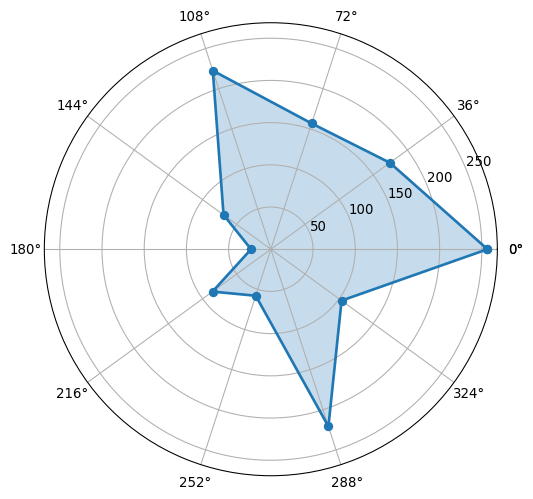

In [111]:
make_radar_chart("Variables extraidas del texto", coeficientes_radar, variables_printable_names, sticks, sticks_str)

#### Vemos la afectacion de los barrios

In [112]:
# Obtengo el valor absoluto de los coeficientes,
# porque me interesa conocer que tanto afecta la variable mas
# si afecta positiva o negativamente

afectacion_absoluta = np.abs(model.coef_)
afectacion_natural = model.coef_

variables_radar = [x for x in feature_cols if "place_name" in x]

# Obtengo los indices de las columnas con los nombres anteriormente establecidos
indices = [i for i in range(len(feature_cols)) if feature_cols[i] in variables_radar]

# Con los indices, obtengo el coeficiente relacionado con las variables
coeficientes_radar = list(afectacion_absoluta[indices])

# Secciono el espacio de estos valores en 5 partes
_, cats = pd.cut(pd.Series(coeficientes_radar), bins = 5, retbins = True)
sticks = np.floor(cats)
sticks_str = [str(s) for s in sticks]

# Establesco nombres para mostrar en el grafico
variables_printable_names = [x.replace("place_name_", "") for x in variables_radar]

In [113]:
coeficientes_natural_radar = list(afectacion_natural[indices])

In [114]:
coeficientes_por_barrio = pd.DataFrame({
        'Barrio': variables_printable_names,
        'Valor absoluto del coeficiente': coeficientes_radar,
        'Valor del coeficiente': coeficientes_natural_radar
    })\
    .sort_values(by = 'Valor absoluto del coeficiente', ascending = False)

In [115]:
coeficientes_por_barrio['Signo del coeficiente'] = np.where(coeficientes_por_barrio['Valor del coeficiente'] > 0, "Positivo", "Negativo")

In [116]:
coeficientes_por_barrio.shape

(46, 4)

Vemos como es el efecto en el precio por metro cuadrado dependiendo del barrio en el que se encuentre la propiedad

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

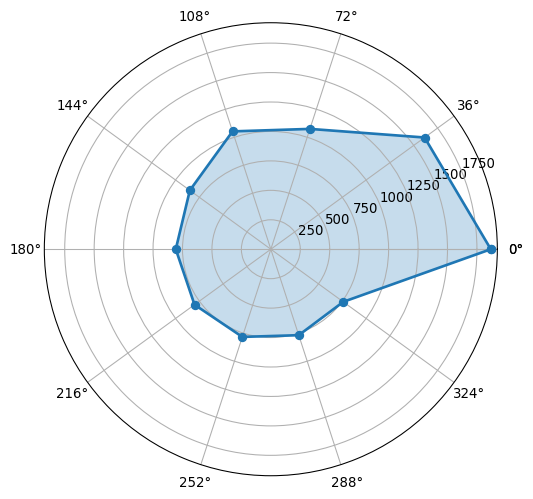

In [117]:
make_radar_chart(
    "Efecto del barrio en el precio por metro cuadrado",
    coeficientes_por_barrio['Valor absoluto del coeficiente'][0: 10].tolist(),
    coeficientes_por_barrio['Barrio'][0: 10].tolist(),
    sticks,
    sticks_str
)

In [ ]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)
sns.barplot(ax = ax, y = "Barrio", x='Valor absoluto del coeficiente', hue = 'Signo del coeficiente', data=coeficientes_por_barrio[0:10])

<AxesSubplot:xlabel='Valor absoluto del coeficiente', ylabel='Barrio'>

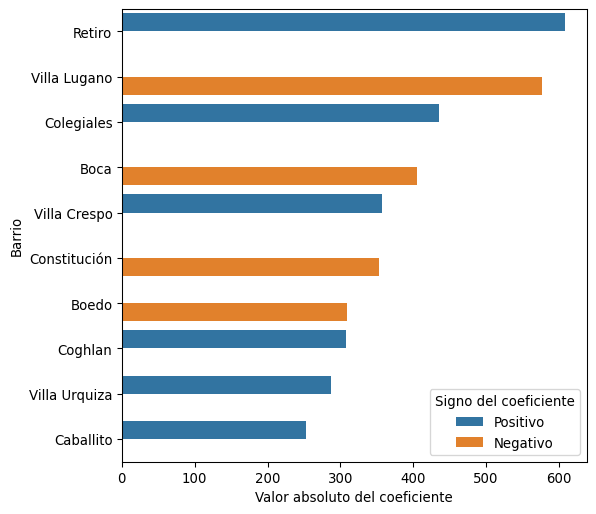

In [118]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(600/my_dpi, 600/my_dpi), dpi=my_dpi)
sns.barplot(ax = ax, y = "Barrio", x='Valor absoluto del coeficiente', hue = 'Signo del coeficiente', data=coeficientes_por_barrio[10:20])

Vemos que algunos Barrios como Puerto Madero hacen que los barrios ganen cierto valor por el hecho de su ubicacion, sin embargo otros barrios como Retiro pierden valor por su ubicacion.

In [119]:
model.intercept_

1605.9200994521912